In [9]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [11]:
apps = pd.read_csv('../input_data/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('../input_data/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('../input_data/jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines="skip")
users = pd.read_csv('../input_data/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('../input_data/test_users.tsv', delimiter='\t',encoding='utf-8')

/var/folders/2v/2pr9cpz926x522gj9g3sd66r0000gn/T/ipykernel_45624/2914488920.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  jobs = pd.read_csv('../input_data/jobs.tsv', delimiter='\t',encoding='utf-8', on_bad_lines="skip")


In [12]:
user_history.head()

UserID  WindowID  Split  Sequence  \
0      47         1  Train         1   
1      47         1  Train         2   
2      47         1  Train         3   
3      72         1  Train         1   
4      72         1  Train         2   

                                            JobTitle  
0  National Space Communication Programs-Special ...  
1                                  Detention Officer  
2                            Passenger Screener, TSA  
3               Lecturer, Department of Anthropology  
4                                  Student Assistant

In [13]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [14]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091706 non-null  object
 4   Requirements  1050478 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


**Pre-process**

There are 3 files which we require to split into training and test sets -
1. apps
2. user_history
3. users

In [15]:
apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']

In [16]:
apps_training.head()

UserID  WindowID  Split          ApplicationDate   JobID
0      47         1  Train  2012-04-04 15:56:23.537  169528
1      47         1  Train  2012-04-06 01:03:00.003  284009
2      47         1  Train  2012-04-05 02:40:27.753    2121
3      47         1  Train  2012-04-05 02:37:02.673  848187
4      47         1  Train  2012-04-05 22:44:06.653  733748

In [17]:
user_history_training = user_history.loc[user_history['Split'] =='Train']
user_history_testing = user_history.loc[user_history['Split'] =='Test']

users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

In [18]:
jobs.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
3      8         1            Route Delivery Drivers   
4      9         1                      Housekeeping   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
3  CITY BEVERAGES Come to work for the best in th...   
4  I make  sure every part of their day is magica...   

                                        Requirements         City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...   Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...    Charlotte    NC   
2  Please refer to the Job Description to view th...  Winter Park    FL   
3  Please refer to the Job Description to view th...      Orlando    FL   
4  Please refer to the Job Description to view th...      Orlando    FL   

  Country   Zip5                StartDate              EndDate  
0      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59  
1      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59  
2      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59  
3      US    NaN  2012-03-03 09:01:10.077  2012-04-02 23:59:59  
4      US    NaN   2012-03-03 09:01:11.88  2012-04-02 23:59:59

In [19]:
import re

removePattern = r'(<(.*?)>)|(&\w+)'
addSpacePattern = r'([;:])|(\\r)|(\\n)'
removeExtraSpaces = r'(\s\s+?)(?=\S)'

jobs['DescCleaned'] = jobs['Description'].astype(str).str.lower()
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['DescCleaned'] = jobs['DescCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))
# Similarly for requirements
jobs['ReqCleaned'] = jobs['Requirements'].astype(str).str.lower()
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removePattern, "", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(addSpacePattern, " ", x))
jobs['ReqCleaned'] = jobs['ReqCleaned'].apply(lambda x: re.sub(removeExtraSpaces, " ", x))


In [20]:
jobs.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
3      8         1            Route Delivery Drivers   
4      9         1                      Housekeeping   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
3  CITY BEVERAGES Come to work for the best in th...   
4  I make  sure every part of their day is magica...   

                                        Requirements         City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...   Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...    Charlotte    NC   
2  Please refer to the Job Description to view th...  Winter Park    FL   
3  Please refer to the Job Description to view th...      Orlando    FL   
4  Please refer to the Job Description to view th...      Orlando    FL   

  Country   Zip5                StartDate              EndDate  \
0      US  20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59   
1      US  28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59   
2      US  32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59   
3      US    NaN  2012-03-03 09:01:10.077  2012-04-02 23:59:59   
4      US    NaN   2012-03-03 09:01:11.88  2012-04-02 23:59:59   

                                         DescCleaned  \
0  security clearance required top secret job num...   
1  no corp. to corp resumes are being considered ...   
2   p/t human resources assistant —— 1-2 years ex...   
3  city beverages come to work for the best in th...   
4  i make sure every part of their day is magical...   

                                          ReqCleaned  
0  skill set network security tools webdefend web...  
1  what you need four year college degree minimum...  
2  please refer to the job description to view th...  
3  please refer to the job description to view th...  
4  please refer to the job description to view th...

In [21]:
jobs.at[0, 'ReqCleaned']

'skill set network security tools webdefend web application firewall (waf), cisco routers, fortigate 3800 firewall series, palo alto 4000 firewall series, cisco asa 5xx firewall platform, cisco fwsm, sourcefire defense center, sourcefire ip sensor platform, bluecoat sg appliance, f5 bigip(reverse proxy). web application tools appdective, fortify sca, hp webinspect, and the like. network vulnerability tools tenable security center, mcafee foundstone scanner, cain and able, l0phtcrack - password cracker, nessus vulnerability scanner, nmap port scanner, and other scanning and vulnerability mapping tools. desirable skills cissp and/or related certifications education and years of experience bs computer science or related discipline minimum of 8 years in it security minimum 4 years in senior/lead position apply here'

In [22]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

City State Country  Locationwise
0       &#60;&#47;b&#62; Brno &#60;b&#62;            CZ             1
1      &#60;&#47;b&#62; Praha &#60;b&#62;            CZ             1
2                                   - Any            CZ            13
3                                29 Palms    CA      US             1
4                                       <            HU             1
...                                   ...   ...     ...           ...
15689                              puebla            MX             1
15690                            san jose            BJ             6
15691                            san jose            UA             1
15692                               seoul            KR             2
15693                              ulsoor            BT             1

[15694 rows x 4 columns]

In [23]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', ascending=False).head()

Country  Locationwise
59      US       1090462
4       AF           560
19      CZ           193
40      MX            93
52      TR            81

In [24]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise', 
                                                                                    ascending=False)

/var/folders/2v/2pr9cpz926x522gj9g3sd66r0000gn/T/ipykernel_45624/609907941.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


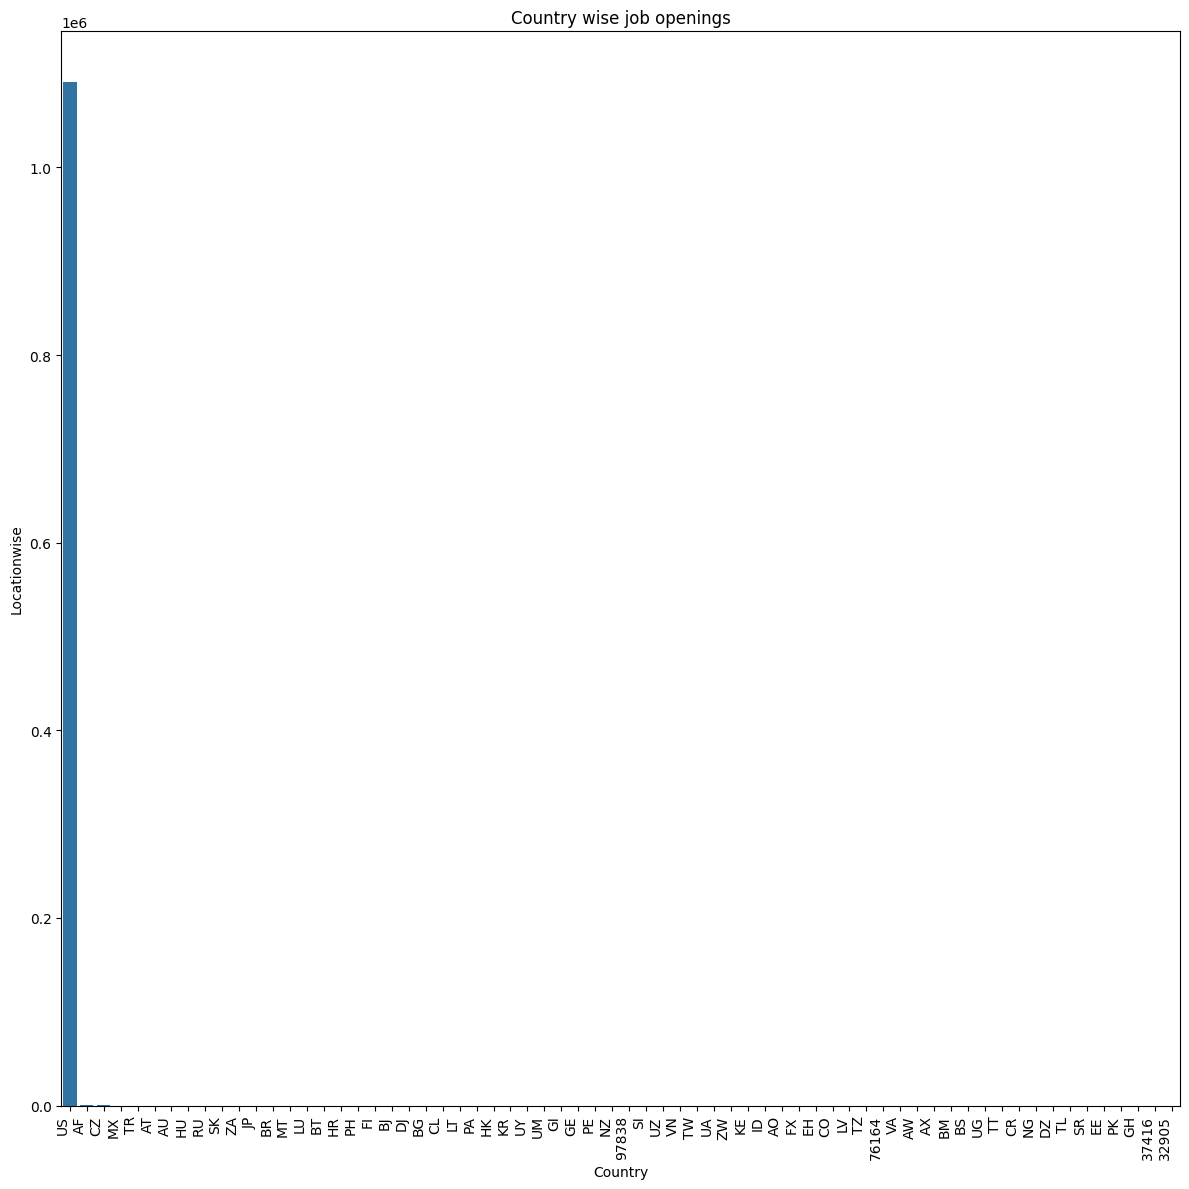

In [25]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

As we can see above, almost all of the jobs are present in the united states. 
Thus, we will only consider jobs in the United States and remove any noise in the dataset. <br>
In below, I will be doing 3 things ->

1. I will remove the city column as it is not really very important and has a lot of noise
2. I will remove the data points which have state as NULL or as numbers
3. I will be considering only US as the country         

In [26]:
jobs = jobs.loc[jobs['Country']=='US']
jobs.drop(columns=['City'])

JobID  WindowID                                              Title  \
0              1         1                   Security Engineer/Technical Lead   
1              4         1                          SAP Business Analyst / WM   
2              7         1                      P/T HUMAN RESOURCES ASSISTANT   
3              8         1                             Route Delivery Drivers   
4              9         1                                       Housekeeping   
...          ...       ...                                                ...   
1091918  1116242         7                              ELECTRICAL SPECIALIST   
1091919  1116253         7                     General and Assistant Managers   
1091920  1116294         7  Assistant Retail Store Manager - Retail Sales ...   
1091921  1116304         7  Career Experience Specialist - Career Services...   
1091922  1116307         7                                  ACCOUNT EXECUTIVE   

                                               Description  \
0        <p>Security Clearance Required:&nbsp; Top Secr...   
1        <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2        <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
3        CITY BEVERAGES Come to work for the best in th...   
4        I make  sure every part of their day is magica...   
...                                                    ...   
1091918  <p><strong><span style="text-decoration: under...   
1091919  <div style="text-align: center"><span style="t...   
1091920  <span>\r<hr>\r<p align="center"><strong>Assist...   
1091921  <p>&nbsp;</p>\r<p><b><span>Macomb Community Co...   
1091922  <p><strong>\r</strong></p>\r<p><strong><strong...   

                                              Requirements State Country  \
0        <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...    DC      US   
1        <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...    NC      US   
2        Please refer to the Job Description to view th...    FL      US   
3        Please refer to the Job Description to view th...    FL      US   
4        Please refer to the Job Description to view th...    FL      US   
...                                                    ...   ...     ...   
1091918  <ul>\r    <li>3-5 years experience as a plant ...    NY      US   
1091919  <ul>\r    <li>5-8 years of <em>Restaurant Mana...    AL      US   
1091920  <span>\r<hr>\r<p align="center"><strong>Assist...    MS      US   
1091921                                    see description    MI      US   
1091922  <ul>\r    <li>Minimum two years proven&nbsp;su...    NY      US   

          Zip5                StartDate              EndDate  \
0        20531  2012-03-07 13:17:01.643  2012-04-06 23:59:59   
1        28217  2012-03-21 02:03:44.137  2012-04-20 23:59:59   
2        32792  2012-03-02 16:36:55.447  2012-04-01 23:59:59   
3          NaN  2012-03-03 09:01:10.077  2012-04-02 23:59:59   
4          NaN   2012-03-03 09:01:11.88  2012-04-02 23:59:59   
...        ...                      ...                  ...   
1091918  12010  2012-06-12 15:18:25.133  2012-07-11 23:59:00   
1091919    NaN  2012-05-29 15:57:34.067  2012-06-28 23:59:00   
1091920  39051   2012-05-25 12:20:17.28  2012-06-24 23:59:00   
1091921  48088  2012-05-24 12:34:38.667  2012-06-23 23:59:00   
1091922    NaN  2012-06-09 02:04:55.433  2012-07-08 23:59:00   

                                               DescCleaned  \
0        security clearance required top secret job num...   
1        no corp. to corp resumes are being considered ...   
2         p/t human resources assistant —— 1-2 years ex...   
3        city beverages come to work for the best in th...   
4        i make sure every part of their day is magical...   
...                                                    ...   
1091918   summary to modify, rebuild, repair, or overha...   
1091919  assistant managers and general managers milo s...   
1091920   assistant retail store manager - retail sal

In [27]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate', 'DescCleaned',
       'ReqCleaned'],
      dtype='object')

In [28]:
jobs.head().transpose()

0  \
JobID                                                         1   
WindowID                                                      1   
Title                          Security Engineer/Technical Lead   
Description   <p>Security Clearance Required:&nbsp; Top Secr...   
Requirements  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...   
City                                                 Washington   
State                                                        DC   
Country                                                      US   
Zip5                                                      20531   
StartDate                               2012-03-07 13:17:01.643   
EndDate                                     2012-04-06 23:59:59   
DescCleaned   security clearance required top secret job num...   
ReqCleaned    skill set network security tools webdefend web...   

                                                              1  \
JobID                                                         4   
WindowID                                                      1   
Title                                 SAP Business Analyst / WM   
Description   <strong>NO Corp. to Corp resumes&nbsp;are bein...   
Requirements  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...   
City                                                  Charlotte   
State                                                        NC   
Country                                                      US   
Zip5                                                      28217   
StartDate                               2012-03-21 02:03:44.137   
EndDate                                     2012-04-20 23:59:59   
DescCleaned   no corp. to corp resumes are being considered ...   
ReqCleaned    what you need four year college degree minimum...   

                                                              2  \
JobID                                                         7   
WindowID                                                      1   
Title                             P/T HUMAN RESOURCES ASSISTANT   
Description   <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
Requirements  Please refer to the Job Description to view th...   
City                                                Winter Park   
State                                                        FL   
Country                                                      US   
Zip5                                                      32792   
StartDate                               2012-03-02 16:36:55.447   
EndDate                                     2012-04-01 23:59:59   
DescCleaned    p/t human resources assistant —— 1-2 years ex...   
ReqCleaned    please refer to the job description to view th...   

                                                              3  \
JobID                                                         8   
WindowID                                                      1   
Title                                    Route Delivery Drivers   
Description   CITY BEVERAGES Come to work for the best in th...   
Requirements  Please refer to the Job Description to view th...   
City                                                    Orlando   
State                                                        FL   
Country                                                      US   
Zip5                                                        NaN   
StartDate                               2012-03-03 09:01:10.077   
EndDate                                     2012-04-02 23:59:59   
DescCleaned   city beverages come to work for the best in th...   
ReqCleaned    please refer to the job description to view th...   

                                                              4  
JobID                                                         9  
WindowID                                                      1  
Title                                              Housekeeping  
Description   I make  sure every part of t

In [29]:
jobs_base_line = jobs.iloc[0:10000,0:8]

In [30]:
jobs_base_line.head()

JobID  WindowID                             Title  \
0      1         1  Security Engineer/Technical Lead   
1      4         1         SAP Business Analyst / WM   
2      7         1     P/T HUMAN RESOURCES ASSISTANT   
3      8         1            Route Delivery Drivers   
4      9         1                      Housekeeping   

                                         Description  \
0  <p>Security Clearance Required:&nbsp; Top Secr...   
1  <strong>NO Corp. to Corp resumes&nbsp;are bein...   
2  <b>    <b> P/T HUMAN RESOURCES ASSISTANT</b> <...   
3  CITY BEVERAGES Come to work for the best in th...   
4  I make  sure every part of their day is magica...   

                                        Requirements         City State  \
0  <p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...   Washington    DC   
1  <p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...    Charlotte    NC   
2  Please refer to the Job Description to view th...  Winter Park    FL   
3  Please refer to the Job Description to view th...      Orlando    FL   
4  Please refer to the Job Description to view th...      Orlando    FL   

  Country  
0      US  
1      US  
2      US  
3      US  
4      US

We added the title to the job description column of the data to run the tfidf on it.

In [31]:
jobs_base_line['Title'] = jobs_base_line['Title'].fillna('')
jobs_base_line['Description'] = jobs_base_line['Description'].fillna('')
jobs_base_line['Description'] = jobs_base_line['Title'] + jobs_base_line['Description']

We will be applying TF-IDF on the description column of the dataset.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_base_line['Description'])

In [35]:
tfidf_matrix.shape

(10000, 515343)

In [36]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [37]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [41]:
jobs_US_base_line = jobs_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_base_line.index, index=jobs_base_line['Title'])

In [42]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]


In [43]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
5117                       SAP Integration Specialist
5409            Senior Business Systems Analyst - SAP
5244                                 Business Analyst
4728           SAP ABAP Developer with PRA experience
Name: Title, dtype: object

In [44]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object